In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from glob import glob
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Preparing the data
import pathlib

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Setting the path to the dataset directory
data_dir = r"/content/drive/MyDrive/Thesis_Kidney_Stone"
data_dir = pathlib.Path(data_dir)

In [5]:
img_height, img_width = 224, 224
batch_size = 64

train_datagen=tf.keras.preprocessing.image.ImageDataGenerator (
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1)

validation_datagen=tf.keras.preprocessing.image.ImageDataGenerator (
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1799 files belonging to 2 classes.
Using 1440 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1799 files belonging to 2 classes.
Using 359 files for validation.


In [8]:
# Training the model
VGG19_model = Sequential()
IMAGE_SIZE = [224,224]
vgg=VGG19(input_shape=IMAGE_SIZE+[3], weights='imagenet', include_top=False)
vgg.output

80134624/80134624 [==============================] - 0s 0us/step


<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [9]:
for layer in vgg.layers:
    layer.trainable = False

In [10]:
folders=glob("/content/drive/MyDrive/Thesis_Kidney_Stone/*")
print(len(folders))

2


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
x=Flatten()(vgg.output)
prediction=Dense(64,activation='relu')(x)
prediction=Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
epochs = 50
history = model.fit(train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50
23/23 [==============================] - 312s 9s/step - loss: 7.1509 - accuracy: 0.7618 - val_loss: 3.2726 - val_accuracy: 0.6797
Epoch 2/50
23/23 [==============================] - 33s 1s/step - loss: 1.0036 - accuracy: 0.8993 - val_loss: 1.9153 - val_accuracy: 0.8050
Epoch 3/50
23/23 [==============================] - 33s 1s/step - loss: 0.2827 - accuracy: 0.9722 - val_loss: 1.3757 - val_accuracy: 0.8329
Epoch 4/50
23/23 [==============================] - 33s 1s/step - loss: 0.1469 - accuracy: 0.9861 - val_loss: 1.1493 - val_accuracy: 0.8914
Epoch 5/50
23/23 [==============================] - 32s 1s/step - loss: 0.0482 - accuracy: 0.9937 - val_loss: 1.1368 - val_accuracy: 0.8969
Epoch 6/50
23/23 [==============================] - 32s 1s/step - loss: 0.0742 - accuracy: 0.9958 - val_loss: 1.6410 - val_accuracy: 0.8440
Epoch 7/50
23/23 [==============================] - 32s 1s/step - loss: 0.0857 - accuracy: 0.9931 - val_loss: 1.3552 - val_accuracy: 0.8774
Epoch 8/50
23/23 [=

In [14]:
best_accuracy = max(history.history['accuracy'])
print("Best Training Accuracy:", best_accuracy)

best_accuracy1 = max(history.history['val_accuracy'])
print("Best Validation Accuracy:", best_accuracy1)


Best Training Accuracy: 0.9986110925674438
Best Validation Accuracy: 0.9192200303077698


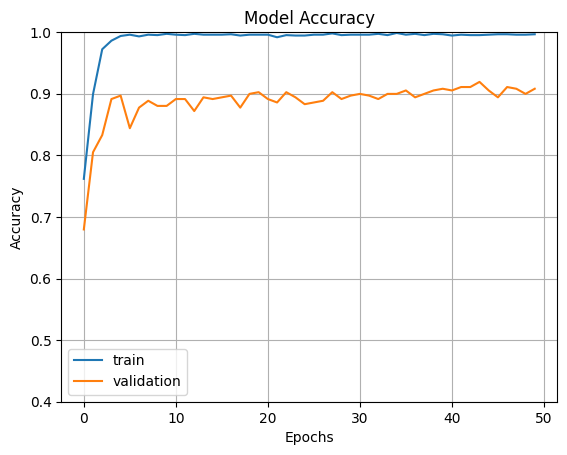

In [15]:
# Evaluating the model
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

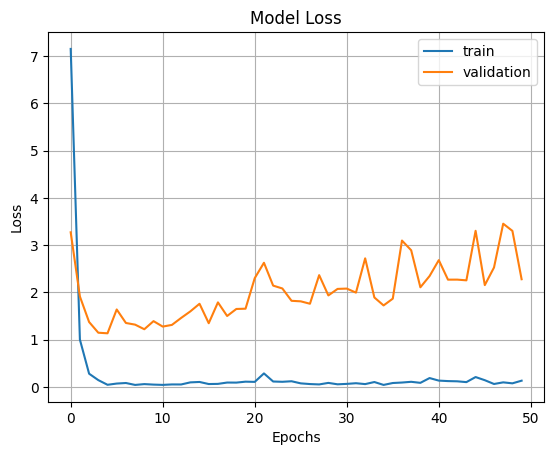

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [17]:
# Generate predictions for the validation dataset
val_predictions = model.predict(val_ds)

# Convert predictions to class labels
val_pred_labels = np.argmax(val_predictions, axis=1)

# Get true labels for the validation dataset
val_true_labels = np.concatenate([y for x, y in val_ds], axis=0)
val_true_labels = np.argmax(val_true_labels, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

6/6 [==============================] - 6s 306ms/step


In [18]:
# Print the confusion matrix for the best_validation_accuracy (best_accuracy1)
print("Confusion Matrix (Best Validation Accuracy - best_accuracy1):")
print(conf_matrix)

Confusion Matrix (Best Validation Accuracy - best_accuracy1):
[[  8  54]
 [ 31 266]]


In [19]:
class_names1 = ['Kidney_stone','Normal']

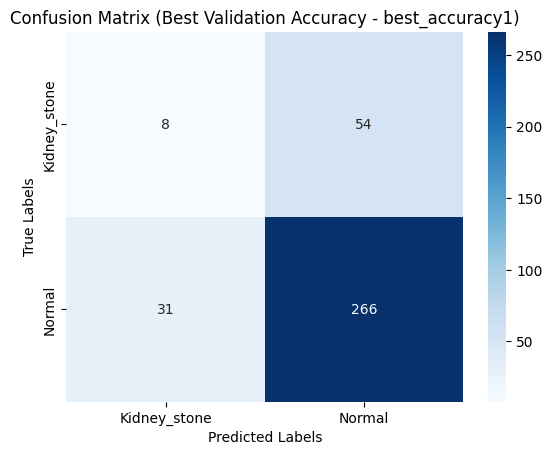

In [20]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names1, yticklabels=class_names1)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Best Validation Accuracy - best_accuracy1)')
plt.show()